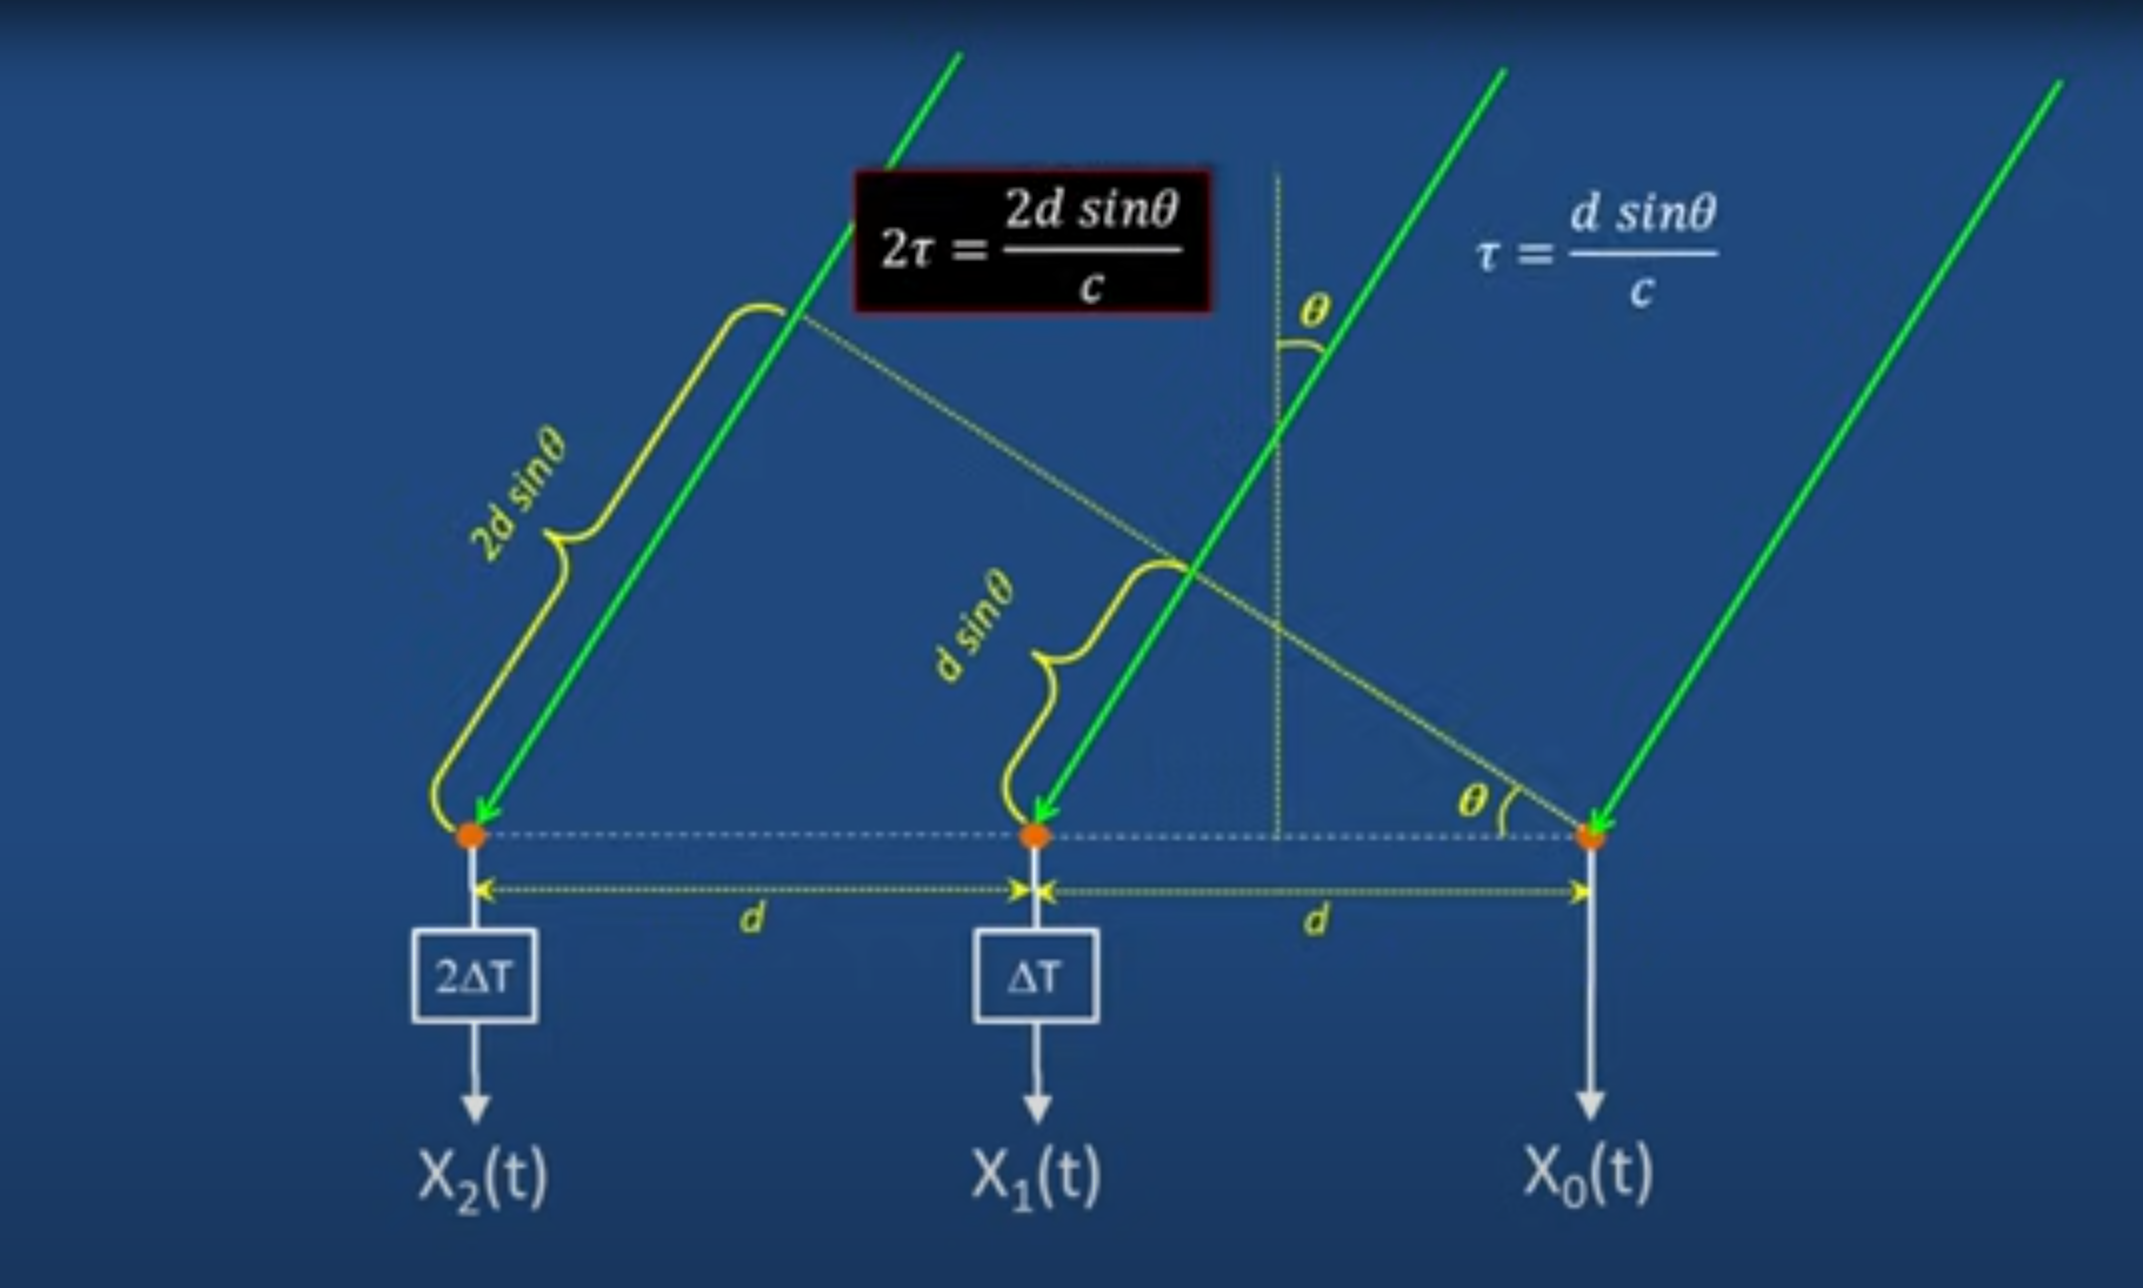

In [27]:

#freq = 1e9
#theta = 0 #np.pi
#lam = spc.c/freq
#d = .5 #half a wavelength
#tao = d*np.sin(theta)/spc.c

In [28]:
import matplotlib.pyplot as plt
import scipy.constants as spc
import numpy as np
import scipy.signal as sig

[Example Code](https://pysdr.org/content/doa.html)

In [29]:
# NEE
def num_nee(B, N):
    freqb = sig.freqz(B, [1])
    

# Setup

In [30]:
def plot_beam(b, title):
    N_fft = 512
    #theta_degrees = 20 # there is no SOI, we arent processing samples, this is just the direction we want to point at
    #theta = theta_degrees / 180 * np.pi
    #w = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # conventional beamformer
    w = np.conj(b) # or else our answer will be negative/inverted
    w_padded = np.concatenate((w.reshape(w.shape[1]), np.zeros(N_fft - Nr))) # zero pad to N_fft elements to get more resolution in the FFT
    w_fft_dB = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(w_padded)))**2) # magnitude of fft in dB
    w_fft_dB -= np.max(w_fft_dB) # normalize to 0 dB at peak
    
    # Map the FFT bins to angles in radians
    theta_bins = np.arcsin(np.linspace(-1, 1, N_fft)) # in radians
    
    # find max so we can add it to plot
    theta_max = theta_bins[np.argmax(w_fft_dB)]
    
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(theta_bins, w_fft_dB) # MAKE SURE TO USE RADIAN FOR POLAR
    ax.plot([theta_max], [np.max(w_fft_dB)],'ro')
    ax.text(theta_max - 0.1, np.max(w_fft_dB) - 4, np.round(theta_max * 180 / np.pi))
    ax.set_theta_zero_location('N') # make 0 degrees point up
    ax.set_theta_direction(-1) # increase clockwise
    ax.set_rlabel_position(55)  # Move grid labels away from other labels
    ax.set_thetamin(-90) # only show top half
    ax.set_thetamax(90)
    ax.set_ylim([-30, 1]) # because there's no noise, only go down 30 dB
    ax.set_title(title)
    plt.show()

In [31]:
sample_rate = 1e6
N = 200 #number of samples

#create a tone
t = np.arange(N)/sample_rate
f_tone = 0.02e6
tx = np.exp(2j*np.pi*f_tone*t)

# Knobs

In [32]:
d = 0.5 # half wavelength spacing
Nr = 20
theta_degrees = 30 # direction of arrival (feel free to change this, it's arbitrary)
theta = theta_degrees / 180 * np.pi # convert to radians
s = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # Steering Vector
print(s) # note that it's 3 elements long, it's complex, and the first element is 1+0j
plot_len = N
mu=.003

[ 1.00000000e+00+0.00000000e+00j  2.83276945e-16-1.00000000e+00j
 -1.00000000e+00-5.66553890e-16j -1.07187544e-15+1.00000000e+00j
  1.00000000e+00+1.13310778e-15j  1.19434012e-15-1.00000000e+00j
 -1.00000000e+00-2.14375088e-15j -2.20498322e-15+1.00000000e+00j
  1.00000000e+00+2.26621556e-15j  2.32744790e-15-1.00000000e+00j
 -1.00000000e+00-2.38868024e-15j -6.00262626e-15+1.00000000e+00j
  1.00000000e+00+4.28750176e-15j  2.57237726e-15-1.00000000e+00j
 -1.00000000e+00-4.40996644e-15j -6.24755562e-15+1.00000000e+00j
  1.00000000e+00+4.53243112e-15j  2.81730662e-15-1.00000000e+00j
 -1.00000000e+00-4.65489580e-15j -6.49248498e-15+1.00000000e+00j]


(20, 1)
(1, 200)
(20, 200)


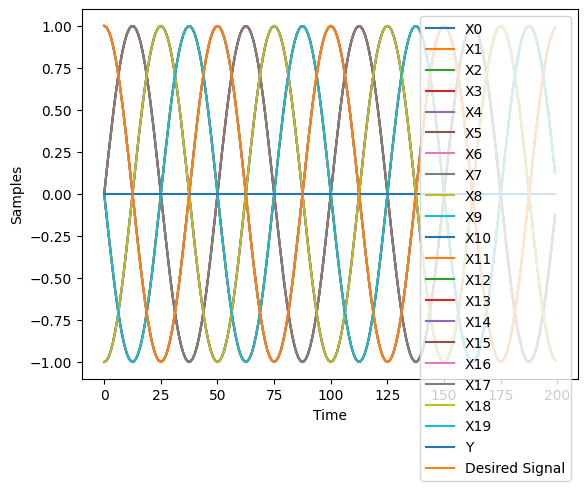

In [33]:
s = s.reshape(-1,1) #make s into a colum vector
print(s.shape) #should be Nrx1
tx = tx.reshape(1,-1) #make tx into a row vector
print(tx.shape) #should be 1xN

X = s@tx
print(X.shape)

#add noise to the signals
#n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
#X = X + 0.5*n # X and n are both 3x10000

#X = X +  0.01*(np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N))
for i in range(len(X)):
    string = 'X'+str(i)
    plt.plot(np.asarray(X[i,:]).squeeze().real[0:200], label=string) # the asarray and squeeze are just annoyances we have to do because we came from a matrix
#plt.plot(np.asarray(X[1,:]).squeeze().real[0:200], label='X1')
#plt.plot(np.asarray(X[2,:]).squeeze().real[0:200], label='X2')

Y = np.zeros_like(X[0])
for i in range(len(X)):
    Y = Y+X[i]
plt.plot(np.asarray(Y).squeeze().real[0:200], label='Y')
plt.plot(np.asarray(tx).squeeze().real[0:200], label='Desired Signal')
plt.xlabel('Time')
plt.legend()
plt.ylabel("Samples")
plt.show()

# Nick LMS

C:\Users\npdho\AppData\Local\Temp\ipykernel_24144\1605069240.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] = (bhat @ xv_real)


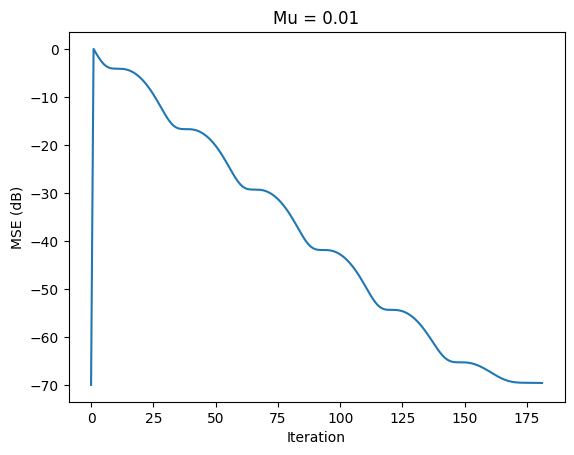

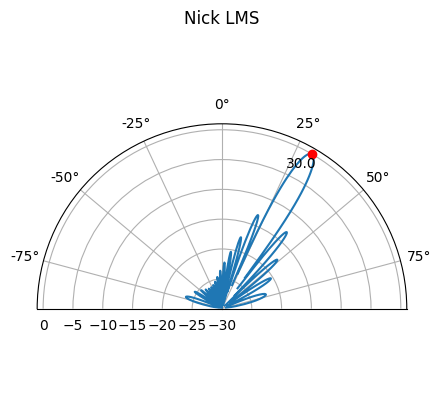

In [34]:


tx
x=X 
L=Nr-1 
N=N
mu = .01
ds = X[0].T.squeeze()
y = np.zeros_like(ds)
e = np.zeros_like(ds)
y = np.zeros_like(ds)
bhat  = np.zeros([1, L+1])

for n in range(L,N):
    #define the input vector
    xv = []
    for i in range(X.shape[0]):
        xv.append(X[i][n])
    xv_real = np.array(xv).real #coining this the Nick LMS
    xv_real = np.flip(xv_real)
    #caclulate the output vector
    y[n] = (bhat @ xv_real)

    #calculate the error
    e[n] = ds[n] - y[n] #starting with the nth sample produces the nth output

    #update the weights
    bhat = bhat + mu*(xv_real*e[n]).T
    
e_NickL = 10*np.log10(abs(e*e)+.0000001) #save for future plot
#freq_resp(bhat.reshape(L+1,1), [1])
eplot = e_NickL
plt.plot(eplot[Nr-2:plot_len])
plt.ylabel('MSE (dB)')
plt.xlabel('Iteration')
string = 'Mu = ' + str(mu)
plt.title(string)
plt.show()
#print("Complex weights", bhat)

plot_beam(bhat, 'Nick LMS')

# Complex LMS

C:\Users\npdho\AppData\Local\Temp\ipykernel_24144\3312659999.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] = (bhat @ xv)# - (bimag @ xv_imag)


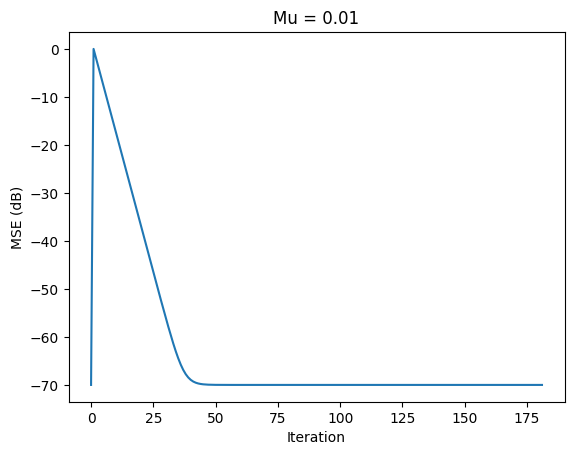

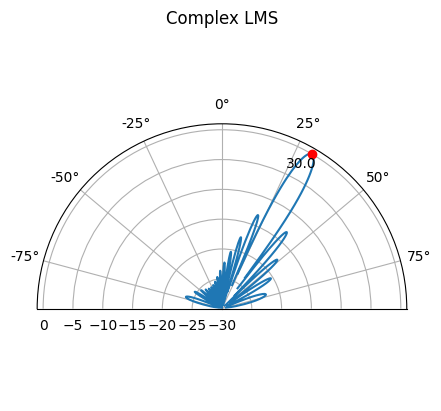

In [35]:
#sandbox

tx
x=X 
L=Nr-1 
N=N
mu = 0.01
ds = tx.T.squeeze() #X[0].T.squeeze()
y = np.zeros_like(ds)
e = np.zeros_like(ds)
y = np.zeros_like(ds)
bhat = np.zeros([1, L+1])

for n in range(L,N):
    #define the input vector
    xv = []
    for i in range(X.shape[0]):
        xv.append(X[i][n])
    xv = np.array(xv)
    xv = np.flip(xv)
    #caclulate the output vector
    y[n] = (bhat @ xv)# - (bimag @ xv_imag)

    #calculate the error
    e[n] = ds[n] - y[n]

    #update the weights
    bhat = bhat + mu*(xv.conj()*e[n]).T
    
    #bhat = bhat + 2*mu*e[n]*xv
e_comL = 10*np.log10(abs(e*e)+.0000001)

eplot = e_comL
plt.plot(eplot[Nr-2:plot_len])
plt.ylabel('MSE (dB)')
plt.xlabel('Iteration')
string = 'Mu = ' + str(mu)
plt.title(string)
plt.show()

#print("Complex weights", bhat)

plot_beam(bhat, 'Complex LMS')

# Normalized Complex LMS

Averagve mu: 0.019047619047619004


C:\Users\npdho\AppData\Local\Temp\ipykernel_24144\2862542755.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] = (bhat @ xv)# - (bimag @ xv_imag)


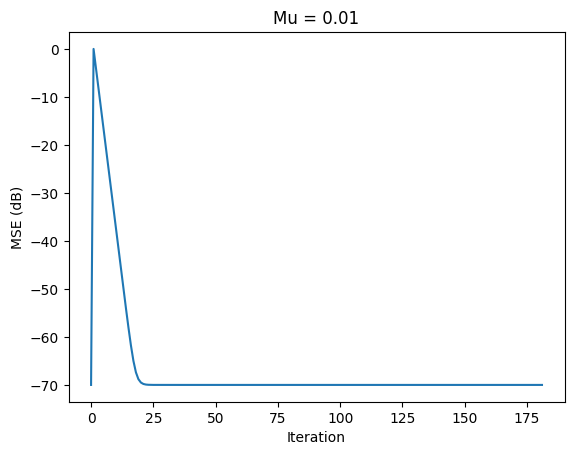

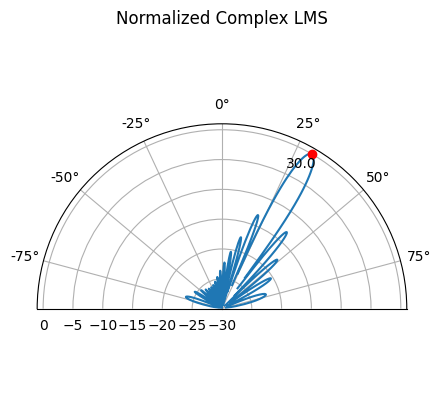

In [36]:
#sandbox

tx
x=X 
L=Nr-1 

N=N
alpha = 1

ds = X[0].T.squeeze()
y = np.zeros_like(ds)
e = np.zeros_like(ds)
y = np.zeros_like(ds)
bhat = np.zeros([1, L+1])
mu_ave = 0
count = 0
for n in range(L,N):
    #define the input vector
    xv = []
    count += 1
    for i in range(X.shape[0]):
        xv.append(X[i][n])
    xv = np.array(xv)
    xv = np.flip(xv)
    #caclulate the output vector
    y[n] = (bhat @ xv)# - (bimag @ xv_imag)

    #calculate the error
    e[n] = ds[n] - y[n]


    #update mu
    x_sum = np.abs(xv*xv)#.conj()/Nr
    x_sum = np.sum(x_sum)
    #print(x_sum)
    mun = (.4)/(alpha + x_sum) #calculating mu normalized
    mu_ave += mun
    #xnorm = np.dot(xv, xv.conj())/(Nr)
    #mun = mu/(.001 + xnorm)
    #update the weights
    bhat = bhat + mun*(xv.conj()*e[n]).T
    
    #bhat = bhat + 2*mu*e[n]*xv
print('Averagve mu:', mu_ave/count)
e_NormL = 10*np.log10(abs(e*e)+.0000001)

eplot = e_NormL
plt.plot(eplot[Nr-2:plot_len])
plt.ylabel('MSE (dB)')
plt.xlabel('Iteration')
string = 'Mu = ' + str(mu)
plt.title(string)
plt.show()

#print("Complex weights", bhat)

plot_beam(bhat, 'Normalized Complex LMS')

In [37]:
(xv)
x_sum = np.abs(xv*xv)

x_sum

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

# M-LMS1

C:\Users\npdho\AppData\Local\Temp\ipykernel_24144\2584393711.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] = (bhat @ xv)# - (bimag @ xv_imag)


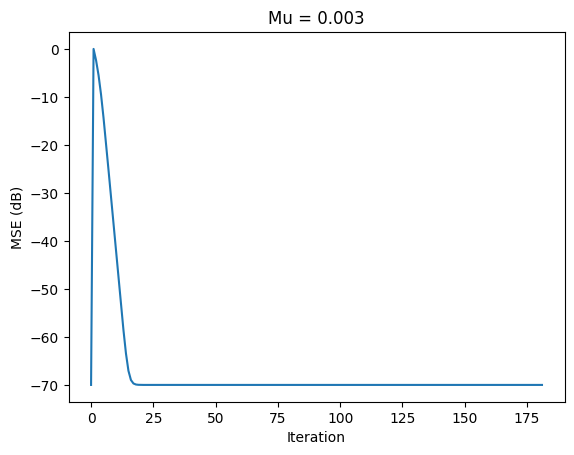

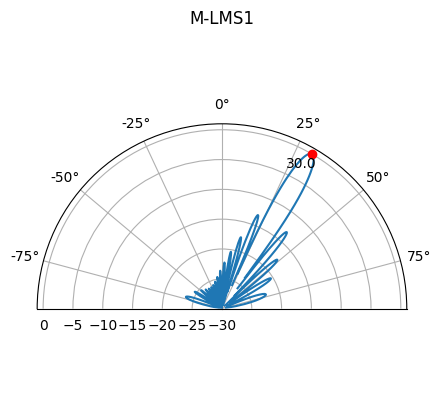

In [38]:

tx
x=X 
L=Nr-1 

N=N
beta = .6
mu = .003
ds = X[0].T.squeeze()
y = np.zeros_like(ds)
e = np.zeros_like(ds)
y = np.zeros_like(ds)
bhat = np.zeros([1, L+1])

for n in range(L,N):
    #define the input vector
    xv = []
    for i in range(X.shape[0]):
        xv.append(X[i][n])
    xv = np.array(xv)
    xv = np.flip(xv)
    #caclulate the output vector
    y[n] = (bhat @ xv)# - (bimag @ xv_imag)

    #calculate the error
    e[n] = ds[n] - y[n]

    #update mu
    #x_sum = (xv*xv)
    #x_sum = np.abs(np.sum(x_sum))
    #mun = (mu)/(alpha + x_sum) #calculating mu normalized

    #x_sum = np.abs(xv*xv)#.conj()/Nr
    #x_sum = np.sum(x_sum)
    #print(x_sum)

    x_sum = np.abs(xv*xv)#.conj()/Nr
    x_sum = np.sum(x_sum)
    mun = (.5)/(alpha + x_sum) #calculating mu normalized
    mu_ave += mun


    term1 = beta * e[n] * e[n].conj()
    term2 = (1 - beta) * e[n] * e[n].conj()
    mun = (mun)/(1 + term1 + term2)

    #update the weights
    bhat = bhat + mun*(xv.conj()*e[n]).T
    
    #bhat = bhat + 2*mu*e[n]*xv
e_M1 = 10*np.log10(abs(e*e)+.0000001)

eplot = e_M1
plt.plot(eplot[Nr-2:plot_len])
plt.ylabel('MSE (dB)')
plt.xlabel('Iteration')
string = 'Mu = ' + str(mu)
plt.title(string)
plt.show()

#print("Complex weights", bhat)

plot_beam(bhat , 'M-LMS1')

# M-LMS2

C:\Users\npdho\AppData\Local\Temp\ipykernel_24144\1836575774.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[n] = (bhat @ xv)# - (bimag @ xv_imag)


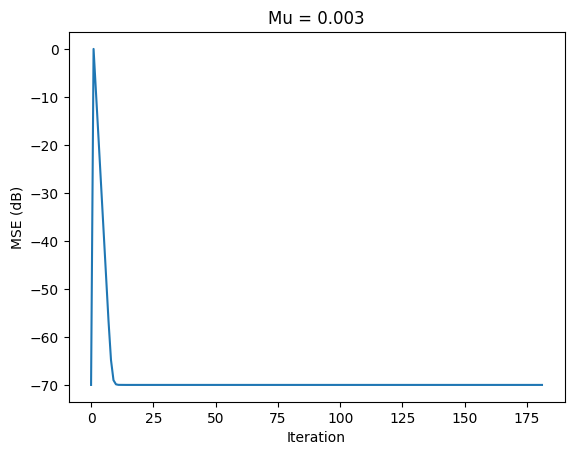

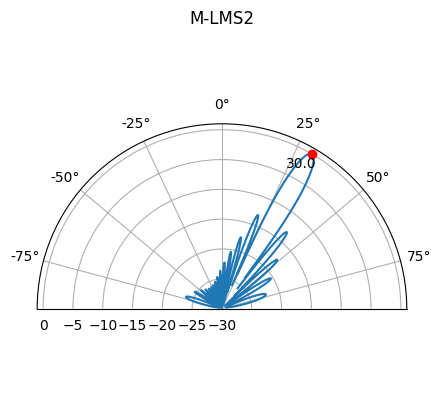

In [39]:

tx
x=X 
L=Nr-1 

N=N


ds = X[0].T.squeeze()
y = np.zeros_like(ds)
e = np.zeros_like(ds)
y = np.zeros_like(ds)
bhat = np.zeros([1, L+1])

for n in range(L,N):
    #define the input vector
    xv = []
    for i in range(X.shape[0]):
        xv.append(X[i][n])
    xv = np.array(xv)
    xv = np.flip(xv)
    #caclulate the output vector
    y[n] = (bhat @ xv)# - (bimag @ xv_imag)

    #calculate the error
    e[n] = ds[n] - y[n]

    #update mu
    #x_sum = (xv*xv)
    #x_sum = np.abs(np.sum(x_sum))
    #mun = (mu)/(alpha + x_sum) #calculating mu normalized

    x_sum = np.abs(xv*xv)#.conj()/Nr
    x_sum = np.sum(x_sum)
    mun = (.7)/(alpha + x_sum) #calculating mu normalized
    mu_ave += mun
    term = mun * e[n] * e[n] * xv[-1]
    mun = (mun)/(1 + term)

    #update the weights
    bhat = bhat + mun*(xv.conj()*e[n]).T
    
    #bhat = bhat + 2*mu*e[n]*xv
e_M2 = 10*np.log10(abs(e*e)+.0000001)

eplot = e_M2
plt.plot(eplot[Nr-2:plot_len])
plt.ylabel('MSE (dB)')
plt.xlabel('Iteration')
string = 'Mu = ' + str(mu)
plt.title(string)
plt.show()

#print("Complex weights", bhat)

plot_beam(bhat, 'M-LMS2')

# Results

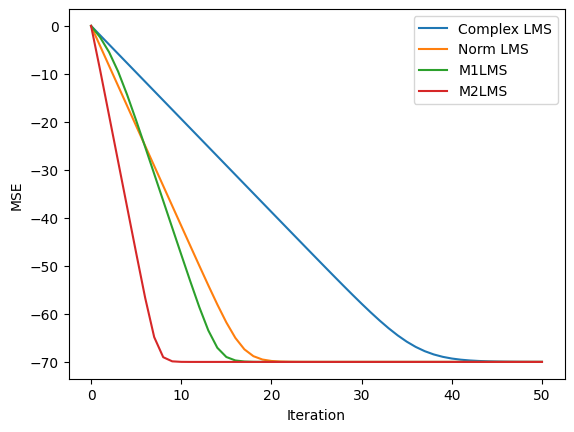

In [44]:
x_vals = np.arange(0,plot_len)
plot_len2 = plot_len -130
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.plot(e_comL[Nr-1:plot_len2], label='Complex LMS')
plt.plot(e_NormL[Nr-1:plot_len2], label='Norm LMS') 
#plt.plot(e_NickL[Nr-1:plot_len2], label='Nick LMS')
plt.plot(e_M1[Nr-1:plot_len2], label='M1LMS')
plt.plot(e_M2[Nr-1:plot_len2], label='M2LMS') 
plt.legend()
plt.show()





In [41]:
pointa=5000
pointb = pointa +1000
plt.plot(np.asarray(yreal)[pointa:pointb], label='Y')
plt.plot(np.asarray(X[0]).squeeze().real[pointa:pointb], label='Tx')
plt.xlabel('Time')
plt.legend()
plt.ylabel("Samples")
plt.show()

NameError: name 'yreal' is not defined

In [663]:
X
X.shape[0]
x = []
for i in range(X.shape[0]):
    x.append(X[i][1])
x = np.array(x)

x.real



array([ 0.94550467, -0.38207727, -0.72320553,  0.91239804, -0.05358362,
       -0.91662025,  0.83274412,  0.16757353, -0.91036919,  0.64070379,
        0.29719744, -0.90506536,  0.49329772,  0.53294898, -0.97265049,
        0.30170572,  0.77728371, -0.88998359,  0.09760187,  0.98310573,
       -0.94382409, -0.07864451,  0.95493332, -0.78883057, -0.36797929,
        1.10044314, -0.53707572, -0.53348814,  0.99722351, -0.3528107 ,
       -0.75220331,  0.89861519, -0.11599798, -0.83868711,  0.78790566,
        0.06667539, -0.84542101,  0.67489319,  0.31891073, -0.93292123,
        0.56932981,  0.60523961, -0.96541918,  0.40256183,  0.69424388,
       -0.8897878 ,  0.09846948,  0.77193911, -0.81857571, -0.1770353 ])

In [664]:
np.zeros(N_fft - Nr).shape

(462,)

In [665]:
int(np.ceil(X.shape[0]/2))

25

In [666]:
(bimag @ xv_real) + (breal @ xv_imag)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 50 is different from 8)

In [92]:
from fractions import Fraction




AutoCorr: 
 [[0.10416667 0.125     ]
 [0.125      0.13888889]]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)

In [87]:
import numpy as np

# Create an initial matrix
matrix = np.array([[1, 2, 3], [4, 5, 6]])

# Row to append
new_row = np.array([[7, 8, 9]])

# Append the row
matrix = np.append(matrix, new_row, axis=0)
print(matrix)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


The fraction is 3602879701896397/288230376151711744
